In [12]:
from PyHessian.pyhessian.hessian import hessian
from PyHessian.density_plot import get_esd_plot
import torch
import torch.nn as nn
import numpy as np
from torchvision import datasets, transforms
from keras.datasets import fashion_mnist as mnist
import matplotlib.pyplot as plt 
from density_plot import get_esd_plot
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [13]:
(train_X, train_y), (test_X, test_y) = mnist.load_data()
torch.manual_seed(42)

In [14]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Using conv layers
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

In [15]:
train_X = (torch.tensor(train_X, dtype=torch.float32)/255).unsqueeze(1)
test_X = (torch.tensor(test_X, dtype=torch.float32)/255).unsqueeze(1)
train_y = torch.tensor(train_y, dtype=torch.int64)
test_y = torch.tensor(test_y, dtype=torch.int64)

In [16]:
dataloader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(train_X, train_y),
    batch_size=64, shuffle=True)
model = Net()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [17]:
losses = []
test_losses = []
train_losses = []
for epoch in range(10):
    for i, (data, target) in enumerate(dataloader):
        optimizer.zero_grad()
        output = model(data)
        #output_test = model(test_X)
        loss = criterion(output, target)
        # loss_test = criterion(output_test, test_y)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if i % 100 == 0:
            print(f"Epoch {epoch}, step {i}, train_loss {loss.item()}")
        # output = model(train_X)
        # loss_train = criterion(output, train_y)
        # output = model(test_X)
        # loss_test = criterion(output, test_y)
        # output_test = model(test_X)
        # test_losses.append(loss_test.item())
        # train_losses.append(loss_train.item())
    #print(loss.item())

Epoch 0, step 0, train_loss 2.2989742755889893
Epoch 0, step 100, train_loss 0.6064432859420776
Epoch 0, step 200, train_loss 0.5071026682853699
Epoch 0, step 300, train_loss 0.4520162045955658
Epoch 0, step 400, train_loss 0.5080047845840454
Epoch 0, step 500, train_loss 0.3092166781425476
Epoch 0, step 600, train_loss 0.1622103601694107
Epoch 0, step 700, train_loss 0.3416781425476074
Epoch 0, step 800, train_loss 0.3117048740386963
Epoch 0, step 900, train_loss 0.3865163326263428
Epoch 1, step 0, train_loss 0.3533536493778229
Epoch 1, step 100, train_loss 0.3041834533214569
Epoch 1, step 200, train_loss 0.4260493814945221
Epoch 1, step 300, train_loss 0.2908560633659363
Epoch 1, step 400, train_loss 0.2606008052825928
Epoch 1, step 500, train_loss 0.23241116106510162
Epoch 1, step 600, train_loss 0.1851295530796051
Epoch 1, step 700, train_loss 0.20832450687885284
Epoch 1, step 800, train_loss 0.3866844177246094
Epoch 1, step 900, train_loss 0.2853041887283325
Epoch 2, step 0, train

In [18]:
# Calculate test accuracy
output = model(test_X)
_, predicted = torch.max(output, 1)
correct = (predicted == test_y).sum().item()
accuracy = correct / test_y.size(0)
print(f"Test accuracy: {accuracy}")

Test accuracy: 0.9239


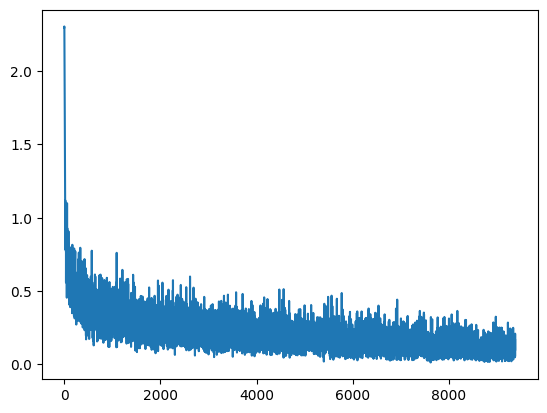

In [19]:
%matplotlib inline
plt.plot(losses)
plt.show()

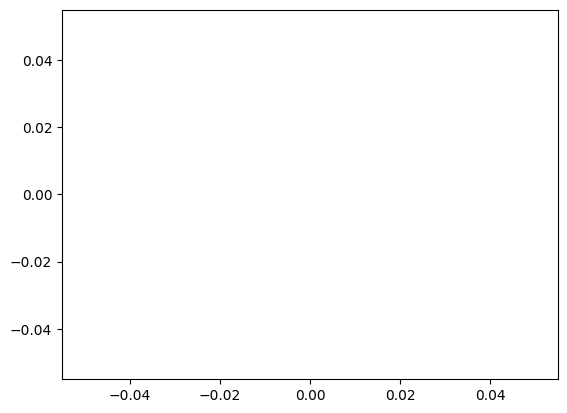

In [20]:
plt.plot(test_losses)
plt.plot(train_losses)
plt.show()

In [21]:
# finding test loss
output = model(train_X)
loss = criterion(output, train_y)
print(loss.item())

KeyboardInterrupt: 

In [22]:
hessian_comp = hessian(model, criterion, data=(test_X, test_y), cuda=False)


c:\Python312\Lib\site-packages\torch\autograd\graph.py:769: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\autograd\engine.cpp:1208.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


In [23]:
trace = hessian_comp.trace()
print("The trace of this model is: %.4f"%(np.mean(trace)))

The trace of this model is: 116.9478


In [13]:
# top_eigenvalues, top_eigenvector = hessian_comp.eigenvalues(top_n=20)
# print("The top two eigenvalues of this model are: ", top_eigenvalues)

In [ ]:
density_eigen, density_weight = hessian_comp.density()
get_esd_plot(density_eigen, density_weight)

In [ ]:
# Save the model
torch.save(model.state_dict(), 'model_cnn_fashion_mnist.pth')

In [15]:
# top_eigenvalues, top_eigenvector = hessian_comp.eigenvalues(top_n=20)
# print(top_eigenvalues)

In [16]:
# top_eigenvector[0][2].shape